<a href="https://colab.research.google.com/github/OoJackoO/MMAI894_Deep-Learning-Course-Project/blob/Nancy_notebook/CNN%20Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%cd /content/drive/MyDrive/MMAI_valid/  

/content/drive/MyDrive/MMAI_valid


In [ ]:
%cd /content/drive/MyDrive/MMAI_Train/  

/content/drive/MyDrive/MMAI_Train


In [ ]:
!unzip '/content/drive/MyDrive/MMAI_Train/train.zip' -d '/content/drive/MyDrive/MMAI_Train'
!unzip '/content/drive/MyDrive/MMAR_valid/valid.zip' -d '/content/drive/MyDrive/MMAI_valid'

In [ ]:
!unzip '/content/drive/MyDrive/MMAI_valid/valid.zip' -d '/content/drive/MyDrive/MMAI_valid'

### **Vision-Transformaers for Classifciation Model**

In [16]:
import os
import cv2
import glob
import time
import shutil
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
sns.set_style('darkgrid')
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
print ('modules loaded')

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


modules loaded


In [33]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/MMAI_Train/',
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode='categorical')

valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow_from_directory('/content/drive/MyDrive/MMAI_valid/',
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode='categorical')

Found 25851 images belonging to 11 classes.
Found 6684 images belonging to 11 classes.


In [10]:
def define_paths(dir):
    filepaths = []
    labels = []
    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    return filepaths, labels

def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

def create_df(tr_dir, val_dir):
    # train dataframe
    files, classes = define_paths(tr_dir)
    train_df = define_df(files, classes)
    
    # valid and test dataframe
    files, classes = define_paths(tr_dir)
    dummy_df = define_df(files, classes)
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123, stratify= strat)
    return train_df, valid_df, test_df


In [12]:
def create_gens(train_df, valid_df, test_df, batch_size):
    img_size = (224, 224)
    channels = 3
    img_shape = (img_size[0], img_size[1], channels)
    ts_length = len(test_df)
    test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size
    def scalar(img):
        return img
    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)
    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)
    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)
    return train_gen, valid_gen, test_gen

In [14]:
def show_images(gen):
    g_dict = gen.class_indices
    classes = list(g_dict.keys())
    images, labels = next(gen)
    plt.figure(figsize= (20, 20))
    length = len(labels)
    sample = min(length, 25)
    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

Found 25850 validated image filenames belonging to 11 classes.


/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 2 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


Found 15510 validated image filenames belonging to 11 classes.


/usr/local/lib/python3.9/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


Found 10340 validated image filenames belonging to 11 classes.


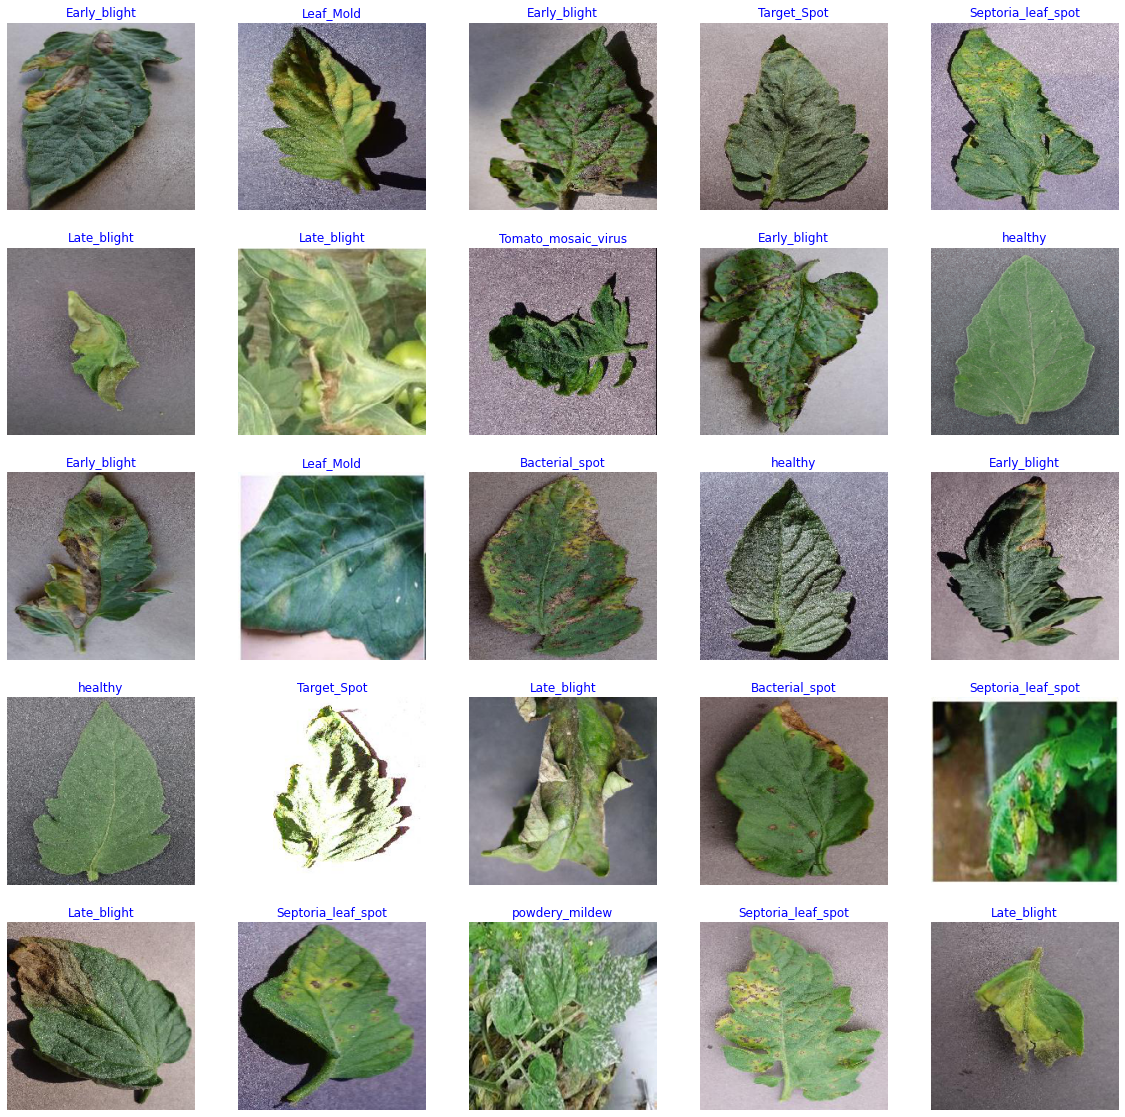

['Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold', 'Septoria_leaf_spot', 'Spider_mites Two-spotted_spider_mite', 'Target_Spot', 'Tomato_Yellow_Leaf_Curl_Virus', 'Tomato_mosaic_virus', 'healthy', 'powdery_mildew']
['Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold', 'Septoria_leaf_spot', 'Spider_mites Two-spotted_spider_mite', 'Target_Spot', 'Tomato_Yellow_Leaf_Curl_Virus', 'Tomato_mosaic_virus', 'healthy', 'powdery_mildew']


In [20]:
# Path to the directory containing the classes
path_to_dir_train = "/content/drive/MyDrive/MMAI_Train/"
path_to_dir_valid = "/content/drive/MyDrive/MMAI_valid/"

train_df, valid_df, test_df = create_df(path_to_dir_train, path_to_dir_valid )

# Get Generators
train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

show_images(train_gen)

# Get the list of classes
classes1 = os.listdir(path_to_dir_train)
classes2 = os.listdir(path_to_dir_valid)

# Print the classes
print(classes1)
print(classes2)

In [17]:

# specify the root directory
root_dir = '/content/drive/MyDrive/MMAI_Train/'

# iterate over the subdirectories
for subdir in os.listdir(root_dir):
    subdir_path = os.path.join(root_dir, subdir)
    if os.path.isdir(subdir_path):
        # get the image file types in the subdirectory
        image_types = list(set([os.path.splitext(filename)[1] for filename in glob.glob(subdir_path + '/*') if os.path.isfile(filename)]))
        print(f'Subdirectory {subdir} contains images of types {image_types}')


Subdirectory Bacterial_spot contains images of types ['.jpg', '.JPG']
Subdirectory Early_blight contains images of types ['.jpg', '.JPG', '.jpeg']
Subdirectory Late_blight contains images of types ['.jpg', '.JPG', '.png']
Subdirectory Leaf_Mold contains images of types ['.jpg', '.JPG']
Subdirectory Septoria_leaf_spot contains images of types ['.jpg', '.JPG', '.jpeg']
Subdirectory Spider_mites Two-spotted_spider_mite contains images of types ['.jpg', '.JPG']
Subdirectory Target_Spot contains images of types ['.JPG']
Subdirectory Tomato_Yellow_Leaf_Curl_Virus contains images of types ['.jpg', '.JPG']
Subdirectory Tomato_mosaic_virus contains images of types ['.jpg', '.JPG', '.png']
Subdirectory healthy contains images of types ['.jpg', '.JPG', '.png']
Subdirectory powdery_mildew contains images of types ['.jpg', '.JPG']


In [18]:
# check image size
sample_df = train_df.sample(n=300, replace=False)
image_size_dict = dict()
for i in range(len(sample_df)):
    fpath = sample_df['filepaths'].iloc[i]
    try:
      img = cv2.imread(fpath)
      h_w = (img.shape[0], img.shape[1])
      image_size_dict[h_w] = image_size_dict.get(h_w, 0) + 1
    except:
        pass

{ k: v for k,v in image_size_dict.items() if v > 10}

{(256, 256): 219, (640, 640): 14, (227, 227): 50}

# **CNN Model**

In [27]:
# Define the hyperparameters
batch_size = 32
num_epochs = 10
image_size = (256,256)

In [32]:
# Define the data augmentation strategy
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)

#path_to_dir_train = "/content/drive/MyDrive/MMAI_Train/"
#path_to_dir_valid = "/content/drive/MyDrive/MMAI_valid/"


# Load the training and validation datasets
train_data = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/MMAI_Train',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)
validation_data = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/MMAI_valid',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)


Found 25851 images belonging to 11 classes.
Found 6684 images belonging to 11 classes.


In [52]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/MMAI_Train/',
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode='categorical')

valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow_from_directory('/content/drive/MyDrive/MMAI_valid/',
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode='categorical')

Found 25851 images belonging to 11 classes.
Found 6684 images belonging to 11 classes.


Found 6684 files belonging to 11 classes.
Using 5348 files for training.


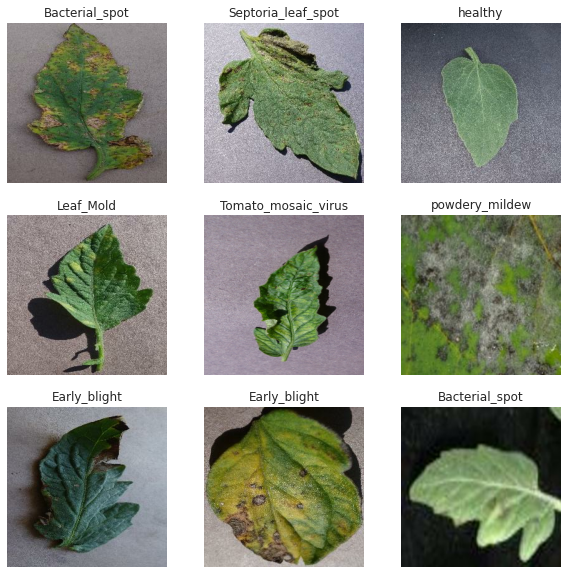

In [54]:

# Define the dataset object using the image_dataset_from_directory method
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/MMAI_valid/',
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(256, 256),
    batch_size=batch_size
)

# Define the class names based on the subdirectories in the dataset directory
class_names = train_ds.class_names

# Visualize the first 9 images in the training dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show()

In [55]:
import tensorflow as tf

# Define the CNN model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

# Compile the model with an optimizer, a loss function, and a metric
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model on the training dataset
model.fit(train_ds, epochs=10)

Epoch 1/10


InvalidArgumentError: ignored

In [25]:
class Convnet(nn.Module):
    def __init__ (self,num_classes=11):
        super(Convnet,self).__init__()
        
        #CONV LAYER 1 : 3x3 FILTERS
        #input_shape = (BATCH_SIZE,3,150,150)
        #output_shape = ((w-f+2p)/s)+1
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=12)
        self.rel1 = nn.ReLU()
        #SHAPE = (BATCH_SIZE,12,150,150)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        #CONV LAYER 2 : 4x4 FILTERS 
        #input_shape = (BATCH_SIZE,12,75,75)
        #output_shape = ((w-f+2p)/s)+1
        self.conv2 = nn.Conv2d(in_channels=12,out_channels=20,kernel_size=4,stride=1,padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=20)
        self.rel2 = nn.ReLU()
        #SHAPE = (BATCH_SIZE,20,74,74)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        #CONV LAYER 3 : 6x6 FILTERS 
        #input_shape = (BATCH_SIZE,32,37,37)
        #output_shape = ((w-f+2p)/s)+1
        self.conv3 = nn.Conv2d(in_channels=20,out_channels=32,kernel_size=6,stride=1,padding=0)
        self.bn3 = nn.BatchNorm2d(num_features=32)
        self.rel3 = nn.ReLU()
        #SHAPE = (BATCH_SIZE,32,32,32)
        
        self.fc = nn.Linear(in_features=32*32*32,out_features=num_classes)
        
    def forward(self,input):
        output = self.conv1(input)
        output = self.bn1(output)
        output = self.rel1(output)
        output = self.pool1(output)
        
        output = self.conv2(output)
        output = self.bn2(output)
        output = self.rel2(output)
        output = self.pool2(output)
        
        output = self.conv3(output)
        output = self.bn3(output)
        output = self.rel3(output)
    
        #output has shape (BATCH_SIZE,32,32,32)
      

NameError: ignored